In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
plt.style.use('ggplot')

In [4]:
!wget https://raw.githubusercontent.com/Daihongchen/Datasets/master/haberman.csv

--2020-09-09 03:04:25--  https://raw.githubusercontent.com/Daihongchen/Datasets/master/haberman.csv
Resolving raw.githubusercontent.com... 151.101.52.133
Connecting to raw.githubusercontent.com|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103 (3.0K) [text/plain]
Saving to: 'haberman.csv'

haberman.csv        100%[===================>]   3.03K  --.-KB/s    in 0s      

2020-09-09 03:04:25 (31.5 MB/s) - 'haberman.csv' saved [3103/3103]



In [11]:
filename = 'haberman.csv'
columns = ['age', 'year', 'nodes', 'class']
df = pd.read_csv(filename, header=None, names=columns)

In [12]:
df.head()

,age,year,nodes,class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [13]:
report = df.describe()
print(report)

              age        year       nodes       class
count  306.000000  306.000000  306.000000  306.000000
mean    52.457516   62.852941    4.026144    1.264706
std     10.803452    3.249405    7.189654    0.441899
min     30.000000   58.000000    0.000000    1.000000
25%     44.000000   60.000000    0.000000    1.000000
50%     52.000000   63.000000    1.000000    1.000000
75%     60.750000   65.750000    4.000000    2.000000
max     83.000000   69.000000   52.000000    2.000000


In [23]:
print(df['class'].value_counts())
print(df['class'].value_counts(normalize=True))

1    225
2     81
Name: class, dtype: int64
1    0.735294
2    0.264706
Name: class, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1178317b8>,
      dtype=object)

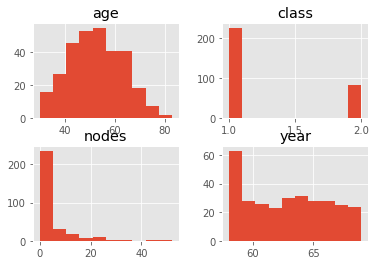

In [21]:
df.hist()

In [28]:
counter = Counter(df['class'].values)
for k, v in counter.items():
    per = v / len(df['class']) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))
#     print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=225, Percentage=73.529%
Class=2, Count=81, Percentage=26.471%


## Model Test and Baseline Result

In [40]:
from collections import Counter
from numpy import mean
from numpy import std
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

In [41]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [42]:
y = LabelEncoder().fit_transform(y)

In [59]:
# load the data
def load_dataset(full_path):
    data = pd.read_csv(full_path, header=None)
    data = data.values
    X, y = data[:, :-1], data[:, -1]
    y = LabelEncoder().fit_transform(y)
    return X, y
    


def brier_skill_score(y_true, y_prob):
    ref_probs = [0.26471 for _ in range(len(y_true))]
    bs_ref = brier_score_loss(y_true, ref_probs)
    bs_model = brier_score_loss(y_true, y_prob)
    
    return 1.0 - (bs_model / bs_ref)

def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define model evaluation metrics
    metric = make_scorer(brier_skill_score, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [62]:
full_path = 'haberman.csv'
X, y = load_dataset(full_path)
print(X.shape, y.shape, Counter(y))

model = DummyClassifier(strategy='prior')

scores = evaluate_model(X, y, model)

print(f'Mean BSS: {mean(scores)}, {std(scores)}')

(306, 3) (306,) Counter({0: 225, 1: 81})
Mean BSS: -0.00010483367619751327, 0.00021871154420730708


# Evaluate Probability Alhorithm

Logistic Regression(LR)

Linear Discriminant Analysis(LDA)

Quadratic Discriminant Analysis(QDA)

Gaussian Naive Bayes(GNB)

Multinomial Naive Bayes(MNB)

Gaussian Process(GPC)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier

In [70]:
def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')
    
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    
    models.append(QuadraticDiscriminantAnalysis())
    names.append('QDA')
    
    models.append(GaussianNB())
    names.append('GNB')
    
    models.append(MultinomialNB())
    names.append('MNB')
    
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    
    return models, names

LR, 0.060463464869234575 (0.1433005845137136)
LDA, 0.06350790304187902 (0.1542833645744821)
QDA, 0.02707971572402724 (0.2207796948149497)
GNB, 0.012194355509524397 (0.21214561239027543)
MNB, -0.21094424432255293 (0.3691807472922246)
GPC, -0.14238899805208502 (0.040617246512972056)


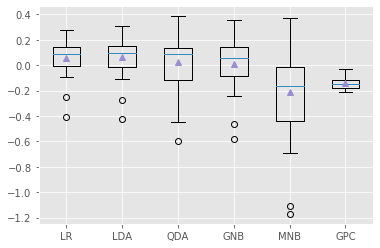

In [74]:
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    print(f'{names[i]}, {mean(scores)} ({std(scores)})')
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

LR and LDA are the best performing. MNB and GPC are not skillful since they showed negative scores.

## Model Evaluaiton with scaled inputs

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

LR, 0.06183251192249042 (0.139784046641763)
LDA, 0.06350790304187905 (0.154283364574482)
QDA, 0.02707971572402729 (0.22077969481494977)
GNB, 0.012194355385266047 (0.21214561258605752)
MNB, nan (nan)
GPC, 0.09717254660831394 (0.13311131023910283)


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


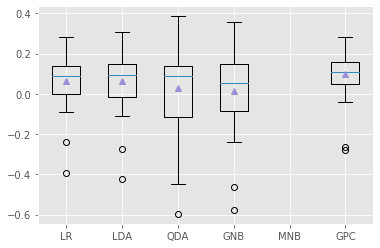

In [87]:
full_path = 'haberman.csv'

X, y = load_dataset(full_path)

models, names = get_models()

results = list()

for i in range(len(models)):
    pipeline = Pipeline(steps=[('t', StandardScaler()), ('m', models[i])])
    
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    print(f'{names[i]}, {mean(scores)} ({std(scores)})')
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Model evaluation with power transform

In [88]:
steps = [('t', MinMaxScaler()), ('t2', PowerTransformer()), ('m', models[i])]
pipeline = Pipeline(steps=steps)
scores = evaluate_model(X, y, pipeline)

LR, 0.11024779452701076 (0.14188867714829576)
LDA, 0.10667914363264484 (0.16411420432184382)
GPC, 0.10030905597224503 (0.13015185800725412)


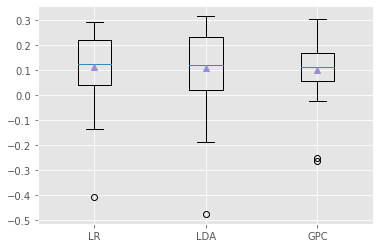

In [93]:
def get_models():
    models, names = list(), list()
# LR
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')
# LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
# GPC
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    return models, names

models, names = get_models()

results = list()
for i in range(len(models)):
    steps = [('t', MinMaxScaler()), ('t2', PowerTransformer()), ('m', models[i])]
    pipeline = Pipeline(steps=steps)
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    print(f'{names[i]}, {mean(scores)} ({std(scores)})')
plt.boxplot(results, labels=names, showmeans=True)
plt.show()